In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from scipy.signal import find_peaks
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from kernel_learning import load_data

In [2]:
# List of experiment directories
# experiment_dirs = [
#     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.0005',
#     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.005',
#     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.05',
#     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_3_bkw0.0005',
#     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_3_bkw0.005',
#     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_3_bkw0.05',
#     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_4_bkw0.0005',
#     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_4_bkw0.005',
#     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_4_bkw0.05',
#  ]
experiment_dirs = [
'/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_2_bkw0.0005',
'/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_2_bkw0.005',
'/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_2_bkw0.05',
'/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_3_bkw0.0005',
'/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_3_bkw0.005',
'/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_3_bkw0.05',
'/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_4_bkw0.0005',
'/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_4_bkw0.005',
'/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_4_bkw0.05',
]

In [3]:
synthetic_data = False

In [4]:
if synthetic_data:
    true_data_path = '/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/summarized_neutron_data_w_bkg_260meV_synthetic_J32.00_Jp-2.60.pt' #synthetic data

    # Load and preprocess data
    true_data_dict = load_data(true_data_path)
    true_exp = true_data_dict['S']
    true_sig = true_data_dict['S_sig']
    true_bkg = true_data_dict['S_bkg']
    s_sig_truth_2d = true_sig.sum(-1).sum(-1)
    s_bkg_truth_2d = true_bkg.sum(-1).sum(-1)

compare a slice

In [5]:
theta = np.pi/4

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage import map_coordinates

# =======================
# Define the helper function
# =======================
def extract_proj_slice(data, theta, num_points=None, order=1):
    """
    Extract a 1D projection slice from a 2D image at an angle theta.
    
    Parameters
    ----------
    data : 2D numpy array
        The input image (time/spatial domain).
    theta : float
        The angle in radians at which to take the slice (0 is horizontal).
    num_points : int, optional
        The number of sample points along the slice. Defaults to the diagonal length.
    order : int, optional
        The interpolation order (default is linear, order=1).
    
    Returns
    -------
    proj_line : 1D numpy array
        The interpolated 1D slice.
    """
    nrows, ncols = data.shape
    if num_points is None:
        num_points = int(np.hypot(nrows, ncols))
    
    L = num_points
    coords = np.linspace(-L/2, L/2, num_points)
    # Compute coordinates along the line at angle theta
    x_coords = coords * np.cos(theta)
    y_coords = coords * np.sin(theta)
    
    # Shift the coordinates so that the line passes through the image center.
    center_x = ncols / 2
    center_y = nrows / 2
    x_coords_shifted = center_x + x_coords
    y_coords_shifted = center_y + y_coords
    
    # Interpolate the 2D data along these coordinates.
    proj_line = map_coordinates(data, [y_coords_shifted, x_coords_shifted], order=order)
    return proj_line


In [7]:
# Define your experiment directories (adjust the list as needed)
experiment_dirs = [
    # '/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_2_bkw0.005',
    # '/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_3_bkw0.005',
    # '/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_4_bkw0.005',
     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.0005',
     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_3_bkw0.0005',
     '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_4_bkw0.0005',
]

/tmp/ipykernel_180422/83756740.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', n_experiments)


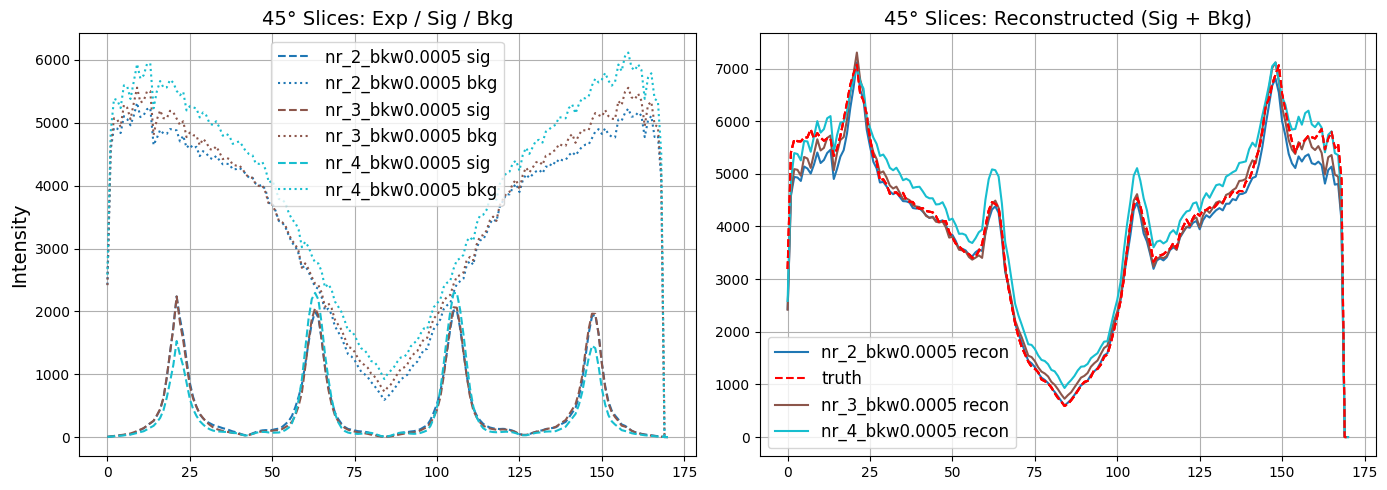

In [8]:
n_experiments = len(experiment_dirs)
cmap = cm.get_cmap('tab10', n_experiments)

def unique_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = {}
    for handle, label in zip(handles, labels):
        if label not in by_label:
            by_label[label] = handle
    ax.legend(list(by_label.values()), list(by_label.keys()), fontsize='large', loc='best')

# =======================
# Create the overall figure (here we show the 45° slices in one plot)
# =======================
# -----------------------
# Plotting
# -----------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=True)

for i, exp_dir in enumerate(experiment_dirs):
    color = cmap(i)
    label_base = os.path.basename(exp_dir)

    data = np.load(os.path.join(exp_dir, 'data_arrays.npz'))
    s_exp = data['s_exp_full_2d'].sum(-1).sum(-1)
    s_sig = data['s_sig_full_2d'].sum(-1).sum(-1)
    s_bkg = data['s_bkg_full_2d'].sum(-1).sum(-1)

    proj_exp = extract_proj_slice(s_exp, theta)
    proj_sig = extract_proj_slice(s_sig, theta)
    proj_bkg = extract_proj_slice(s_bkg, theta)
    proj_recon = proj_bkg + proj_sig

    # Left subplot: raw signal components
    ax1.plot(proj_sig, color=color, linestyle='--', label=f'{label_base} sig')
    ax1.plot(proj_bkg, color=color, linestyle=':',  label=f'{label_base} bkg')

    # Right subplot: reconstruction (bkg + sig)
    ax2.plot(proj_recon, color=color, linestyle='-', label=f'{label_base} recon')
    ax2.plot(proj_exp, color='red', linestyle='--', label='truth')

if synthetic_data:
    proj_sig_truth = extract_proj_slice(s_sig_truth_2d , theta)
    proj_bkg_truth = extract_proj_slice(s_bkg_truth_2d , theta)

    ax1.plot(proj_sig_truth, color='black', linestyle='--', label='True sig')
    ax1.plot(proj_bkg_truth, color='black', linestyle=':',  label='True bkg')

# -----------------------
# Formatting
# -----------------------
ax1.set_title('45° Slices: Exp / Sig / Bkg', fontsize=14)
#ax1.set_xlabel('Sample Index', fontsize=14)
ax1.set_ylabel('Intensity', fontsize=14)
ax1.grid(True)
unique_legend(ax1)

ax2.set_title('45° Slices: Reconstructed (Sig + Bkg)', fontsize=14)
#ax2.set_xlabel('Sample Index', fontsize=14)
ax2.grid(True)
unique_legend(ax2)

plt.tight_layout()
plt.show()

compare spectrumn (Fourier Projection Slice)
- $lambda is chosen with the value where s_sig are zero outside its local supports

In [27]:
experiment_dirs = [
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.0005',
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_3_bkw0.0005',
    # '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_4_bkw0.0005',
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.005',
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_3_bkw0.005',
    # '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_4_bkw0.005',
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.05',
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_3_bkw0.05',
    # '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_4_bkw0.05'
]

In [32]:
data_path = '/pscratch/sd/z/zhantao/yuan/pscratch/sd/y/yn754/data/S2e/summarized_neutron_data_w_bkg_260meV_ML.pt' #experimental data

data_dict = torch.load(data_path,weights_only=False)

In [92]:
import numpy as np

a = 0.2  # you can set to 1 if you want symbolic units
N = 121
delta_q = 4 * (2 * np.pi / 1) / N

x_over_a = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(N, d=delta_q)) / 1


/tmp/ipykernel_180422/45591656.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', n_experiments)


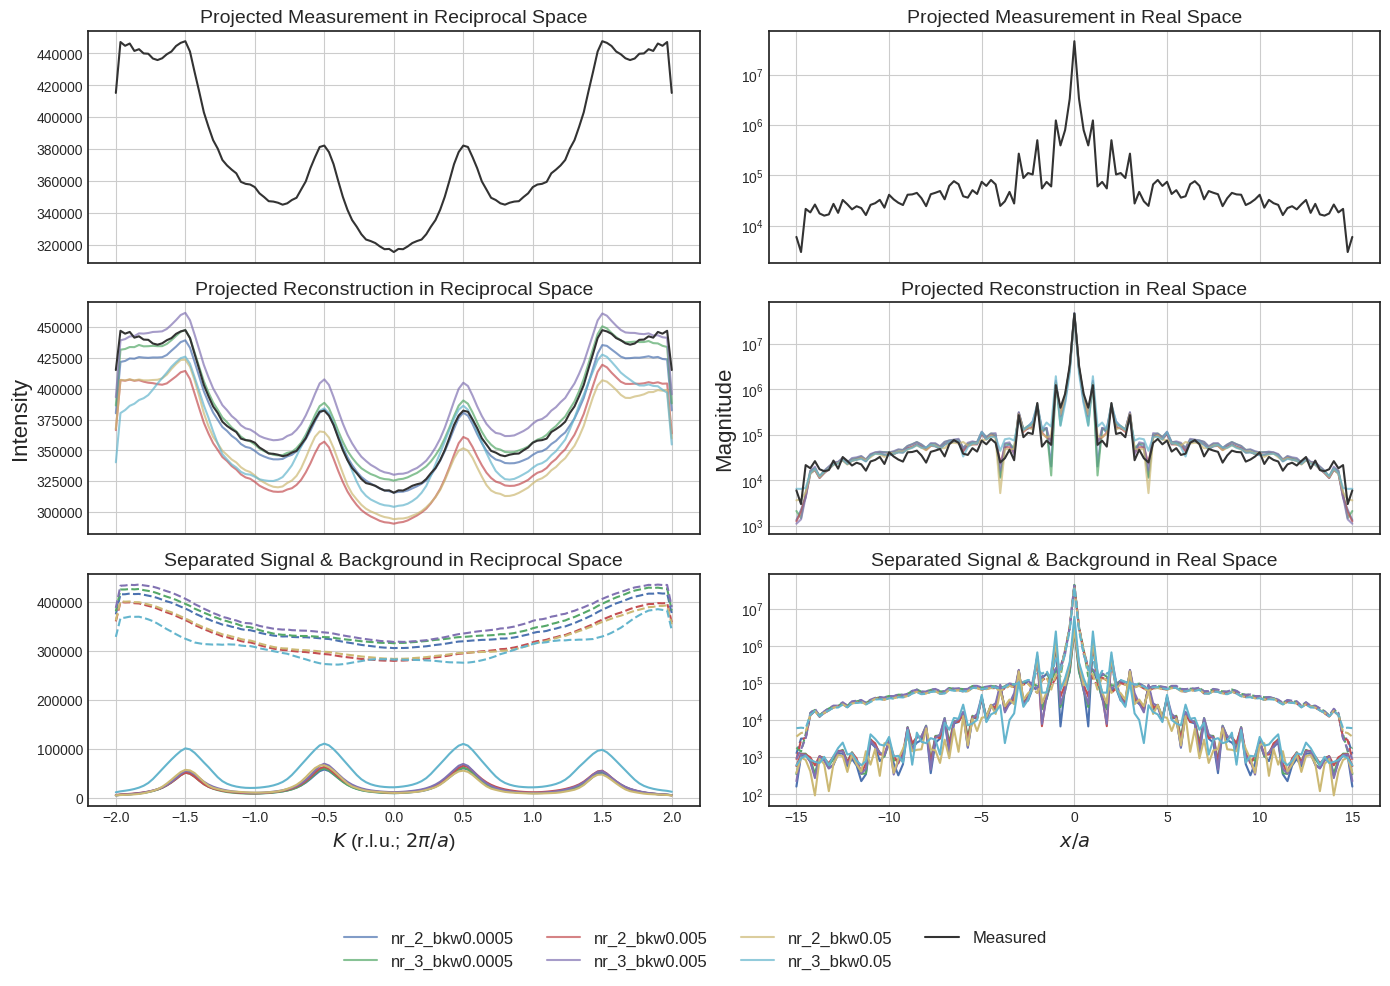

In [93]:
import seaborn as sns
# Set a dark theme/style for Seaborn plots
plt.style.use('seaborn-v0_8-deep')

# Create a colormap with as many distinct colors as experiments
n_experiments = len(experiment_dirs)
cmap = cm.get_cmap('tab10', n_experiments)

# Create overall figure with 3 rows x 2 columns of subplots.
fig, axes = plt.subplots(3, 2, figsize=(14, 9), sharex='col')

# Storage for all legend entries
legend_handles = []
legend_labels = []

for i, exp_dir in enumerate(experiment_dirs):
    # color = cmap(i)
    color = f'C{i}'
    label = os.path.basename(exp_dir)

    npz_file = os.path.join(exp_dir, 'data_arrays.npz')
    data = np.load(npz_file)
    
    # Extract arrays
    S_expt_plot = data['s_exp_full_2d'].sum(-1).sum(-1)
    S_sig_plot  = data['s_sig_full_2d'].sum(-1).sum(-1)
    S_bkg_plot  = data['s_bkg_full_2d'].sum(-1).sum(-1)

    # Compute spatial projections
    proj_exp = np.sum(S_expt_plot, axis=0)
    proj_sig = np.sum(S_sig_plot, axis=0)
    proj_bkg = np.sum(S_bkg_plot, axis=0)

    # Compute Fourier slices
    slice_exp2 = np.fft.fftshift(np.fft.fft2(S_expt_plot))[S_expt_plot.shape[0] // 2]
    slice_sig2 = np.fft.fftshift(np.fft.fft2(S_sig_plot))[S_sig_plot.shape[0] // 2]
    slice_bkg2 = np.fft.fftshift(np.fft.fft2(S_bkg_plot))[S_bkg_plot.shape[0] // 2]

    # Only plot proj_exp once (first iteration)
    if i == 0:
        axes[0, 0].plot(data_dict['grid']['h_grid'], proj_exp, color='0.2', label='Measured', zorder=100)
        axes[1, 0].plot(data_dict['grid']['h_grid'], proj_exp, color='0.2', zorder=100, linewidth=1.5)
        axes[0, 1].plot(x_over_a, np.abs(slice_exp2), color='0.2', zorder=100)
        axes[1, 1].plot(x_over_a, np.abs(slice_exp2), color='0.2', zorder=100, linewidth=1.5)

    # Row 0: Measured (only once)
    # axes[0, 1].plot(np.abs(slice_exp2), color='k')

    # Row 1: Reconstruction
    recon_spatial = proj_bkg + proj_sig
    h1, = axes[1, 0].plot(data_dict['grid']['h_grid'], recon_spatial, color=color, alpha=0.7, label=label)
    recon_freq = np.abs(slice_bkg2 + slice_sig2)
    h2, = axes[1, 1].plot(x_over_a, recon_freq, color=color, alpha=0.7)

    # Row 2: Signal and Background 
    proj_sig_scaled = proj_sig 
    proj_bkg_scaled = proj_bkg 

    axes[2, 0].plot(data_dict['grid']['h_grid'], proj_bkg_scaled, color=color, linestyle='--')
    axes[2, 0].plot(data_dict['grid']['h_grid'], proj_sig_scaled, color=color, linestyle='-')

    axes[2, 1].plot(x_over_a, np.abs(slice_bkg2), color=color, linestyle='--')
    axes[2, 1].plot(x_over_a, np.abs(slice_sig2), color=color, linestyle='-')

    # Local maxima
    mag_sig = np.abs(slice_sig2)
    mag_bkg = np.abs(slice_bkg2)
    idx1 = find_peaks(mag_sig, prominence=5e4)[0]
    idx2 = find_peaks(mag_bkg, prominence=5e4)[0]
    # idx_union = np.union1d(idx1, idx2)

    # axes[2, 1].plot(idx1, mag_sig[idx1], 'ro', alpha=0.7, markersize=4)
    # axes[2, 1].plot(idx2, mag_bkg[idx2], 'ko', alpha=0.7, markersize=4)
    # axes[1, 1].plot(idx_union, recon_freq[idx_union], 'go', alpha=0.7, markersize=4)

    # idx1_spatial = find_peaks(proj_sig, prominence=5)[0]
    # idx2_spatial = find_peaks(proj_bkg, prominence=5)[0]
    # idx_union_spatial = np.union1d(idx1_spatial, idx2_spatial)

    # axes[2, 0].plot(idx1_spatial, proj_sig_scaled[idx1_spatial], 'ro', alpha=0.7, markersize=4)
    # axes[2, 0].plot(idx2_spatial, proj_bkg_scaled[idx2_spatial], 'ko', alpha=0.7, markersize=4)
    # axes[1, 0].plot(idx_union_spatial, recon_spatial[idx_union_spatial], 'go', alpha=0.7, markersize=4)

    # Store legend handles
    legend_handles.append(h1)
    legend_labels.append(label)

# Titles and axis labels
# axes[0, 0].set_title(r'$f(x)$ (Measured)', fontsize=14)
# axes[0, 1].set_title(r'$|\hat f(\epsilon)|$ (Measured)', fontsize=14)
# axes[1, 0].set_title(r'$f(x)$ (Reconstructed)', fontsize=14)
# axes[1, 1].set_title(r'$|\hat f(\epsilon)|$ (Reconstructed)', fontsize=14)
# axes[2, 0].set_title(r'Signal & Background (Separated)', fontsize=14)
# axes[2, 1].set_title(r'Signal & Background Fourier', fontsize=14)


axes[0, 0].set_title(r'Projected Measurement in Reciprocal Space', fontsize=14)
axes[0, 1].set_title(r'Projected Measurement in Real Space', fontsize=14)
axes[1, 0].set_title(r'Projected Reconstruction in Reciprocal Space', fontsize=14)
axes[1, 1].set_title(r'Projected Reconstruction in Real Space', fontsize=14)
axes[2, 0].set_title(r'Separated Signal & Background in Reciprocal Space', fontsize=14)
axes[2, 1].set_title(r'Separated Signal & Background in Real Space', fontsize=14)

# axes[2, 0].set_xlabel(r'Pixel', fontsize=14)
axes[2, 0].set_xlabel('$K$ (r.l.u.; $2\pi/a$)', fontsize=14)
axes[2, 1].set_xlabel(r'$x / a$', fontsize=14)
axes[1, 0].set_ylabel(r'Intensity', fontsize=16)
axes[1, 1].set_ylabel(r'Magnitude', fontsize=16)

axes[0, 1].set_yscale('log')
axes[1, 1].set_yscale('log')
axes[2, 1].set_yscale('log')

# Style
for ax in axes.flat:
    ax.grid(True)

# Add single global legend outside the figure (bottom center)
fig.legend(handles=legend_handles + [plt.Line2D([], [], color='0.2', label='Measured')],
           labels=legend_labels + ['Measured'],
           loc='lower center', bbox_to_anchor=(0.5, -0.1),
           ncol=4, fontsize='large', frameon=False)

# plt.style.use('seaborn-v0_8-white')
plt.tight_layout(rect=[0, 0.03, 1, 1])  # leave space at bottom for legend

# Save
filename = os.path.join('../figures', 'fourier_projection_slice_overall.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()


The choice of $lambda

In [11]:
# List of experiment directories
experiment_dirs = [
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.0005',
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.005',
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.05',
]


/tmp/ipykernel_180422/3350759765.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', n_experiments)


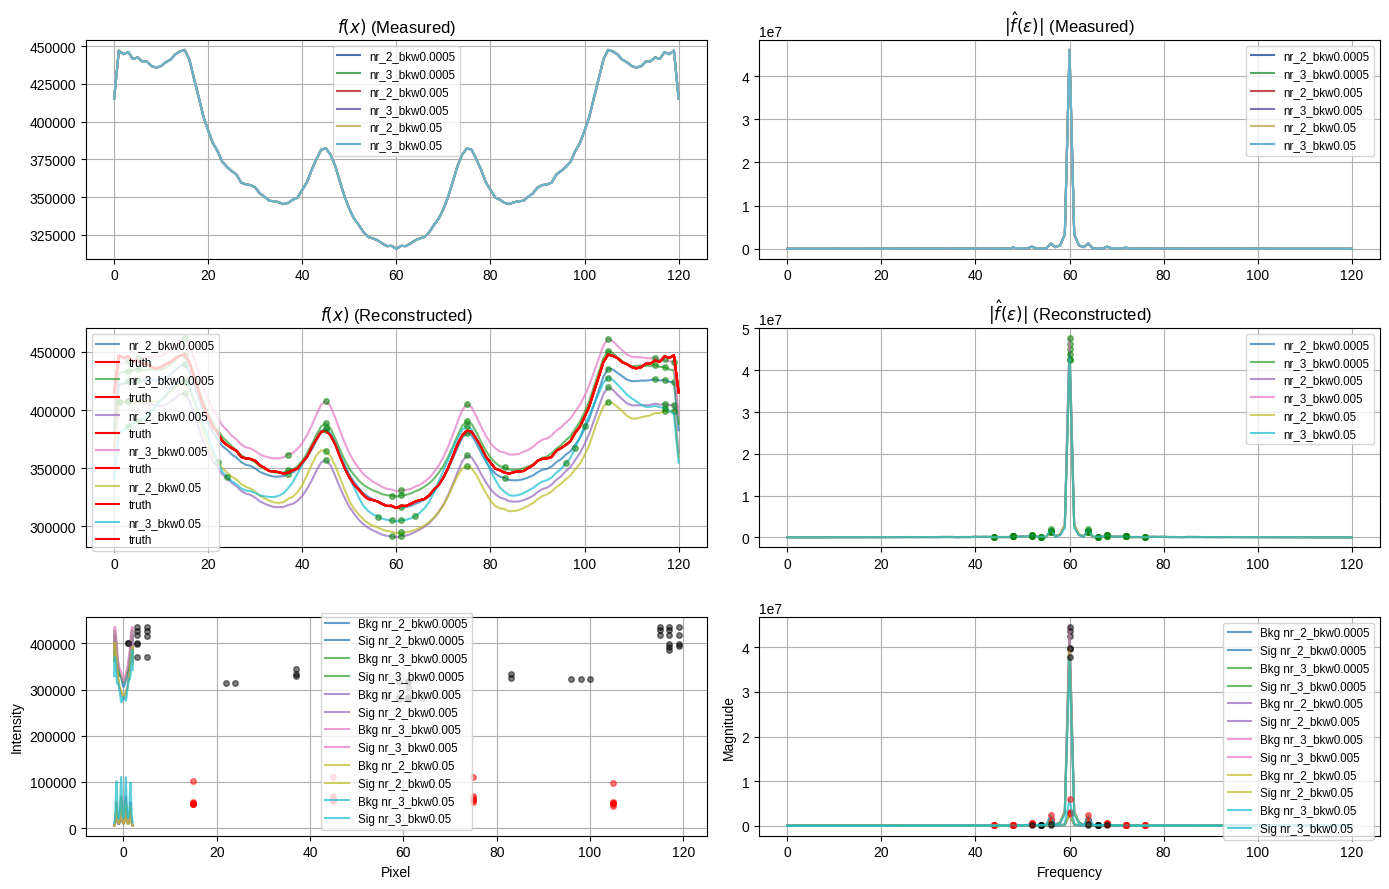

In [ ]:
# Create a colormap with as many distinct colors as experiments
n_experiments = len(experiment_dirs)
cmap = cm.get_cmap('tab10', n_experiments)

# A helper function to create a unique legend (avoiding duplicate labels)
def unique_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = {}
    for handle, label in zip(handles, labels):
        if label not in by_label:
            by_label[label] = handle
    ax.legend(list(by_label.values()), list(by_label.keys()), fontsize='small', loc='best')

# Create overall figure with 3 rows x 2 columns of subplots.
fig, axes = plt.subplots(3, 2, figsize=(14, 9))

# Loop over experiments and add curves in each subplot.
for i,exp_dir in enumerate(experiment_dirs):

    color = cmap(i)

    npz_file = os.path.join(exp_dir, 'data_arrays.npz')
    data = np.load(npz_file)
    
    # Extract arrays
    S_expt_plot = data['s_exp_full_2d'].sum(-1).sum(-1)
    S_sig_plot  = data['s_sig_full_2d'].sum(-1).sum(-1)
    S_bkg_plot  = data['s_bkg_full_2d'].sum(-1).sum(-1)
 
    # Compute spatial projections (sum over rows)
    proj_exp = np.sum(S_expt_plot, axis=0)
    proj_sig = np.sum(S_sig_plot, axis=0)
    proj_bkg = np.sum(S_bkg_plot, axis=0)
    
    # Compute Fourier slices by taking the 2D FFT and selecting the middle row:
    slice_exp2 = np.fft.fftshift(np.fft.fft2(S_expt_plot))[S_expt_plot.shape[0] // 2]
    slice_sig2 = np.fft.fftshift(np.fft.fft2(S_sig_plot))[S_sig_plot.shape[0] // 2]
    slice_bkg2 = np.fft.fftshift(np.fft.fft2(S_bkg_plot))[S_bkg_plot.shape[0] // 2]
    
    # Use the directory's base name as the label.
    label = os.path.basename(exp_dir)
    
    # --------------------------
    # Row 0: "Truth" (measured) curves
    # Left: Spatial domain curve of measured data
    axes[0, 0].plot(proj_exp, label=label)
    axes[0, 0].set_title(r'$f(x)$ (Measured)')
    # Right: Fourier domain (absolute value) of measured data
    axes[0, 1].plot(np.abs(slice_exp2), label=label)
    axes[0, 1].set_title(r'$|\hat f(\epsilon)|$ (Measured)')

    # --------------------------
    # Row 1: "Reconstructed" curves (background + signal)
    # Left: Spatial reconstruction
    recon_spatial = proj_bkg + proj_sig
    axes[1, 0].plot(recon_spatial, color = color, alpha=0.7, label=label)
    axes[1, 0].plot(proj_exp, color = 'red',label = 'truth')
    axes[1, 0].set_title(r'$f(x)$ (Reconstructed)')
    
    # Right: Fourier reconstruction from signal and background
    recon_freq = np.abs(slice_bkg2 + slice_sig2)
    axes[1, 1].plot(recon_freq, color=color, alpha=0.7, label=label)
    axes[1, 1].set_title(r'$|\hat f(\epsilon)|$ (Reconstructed)')
    
    # --------------------------
    # Row 2: Plots of signal and background separately
    # Left: Spatial domain: Plot background (black) and signal (red)
    axes[2, 0].plot(proj_bkg, color=color, alpha=0.7, label=f'Bkg {label}')
    axes[2, 0].plot(proj_sig, color=color, alpha=0.7, label=f'Sig {label}')
    axes[2, 0].set_xlabel('Pixel')
    axes[2, 0].set_ylabel('Intensity')
    
    # Right: Fourier domain: Plot background (black) and signal (red)
    axes[2, 1].plot(np.abs(slice_bkg2), color=color, alpha=0.7, label=f'Bkg {label}')
    axes[2, 1].plot(np.abs(slice_sig2), color=color, alpha=0.7, label=f'Sig {label}')
    axes[2, 1].set_xlabel('Frequency')
    axes[2, 1].set_ylabel('Magnitude')
    
    # --------------------------
    # Add local maxima to aid the comparison:
    
    # Frequency domain (row 2, col 2):
    mag_sig = np.abs(slice_sig2)
    mag_bkg = np.abs(slice_bkg2)
    idx1 = find_peaks(mag_sig, prominence=5e4)[0]
    idx2 = find_peaks(mag_bkg, prominence=5e4)[0]
    idx_union = np.union1d(idx1, idx2)
    
    # Mark the peaks on the Fourier domain individual plot (row 2, col 2)
    axes[2, 1].plot(idx1, mag_sig[idx1], 'ro', alpha=0.5, markersize=4)
    axes[2, 1].plot(idx2, mag_bkg[idx2], 'ko', alpha=0.5, markersize=4)
    
    # Mark the combined peaks on the reconstructed FFT curve (row 1, col 2)
    axes[1, 1].plot(idx_union, recon_freq[idx_union], 'go', alpha=0.5, markersize=4)
    
    # Spatial domain (row 2, col 1):
    idx1_spatial = find_peaks(proj_sig, prominence=5)[0]
    idx2_spatial = find_peaks(proj_bkg, prominence=5)[0]
    idx_union_spatial = np.union1d(idx1_spatial, idx2_spatial)
    
    # Mark the peaks on the individual curves of the spatial domain plot (row 2, col 1)
    axes[2, 0].plot(idx1_spatial, proj_sig[idx1_spatial], 'ro', alpha=0.5, markersize=4)
    axes[2, 0].plot(idx2_spatial, proj_bkg[idx2_spatial], 'ko', alpha=0.5, markersize=4)
    
    # Mark combined peaks on the reconstructed spatial signal (row 1, col 1)
    axes[1, 0].plot(idx_union_spatial, recon_spatial[idx_union_spatial], 'go', alpha=0.5, markersize=4)

# --------------------------
# Final formatting adjustments
for ax in axes.flat:
    ax.grid(True)
    # Use a smaller font-size for the legends if needed.
    ax.legend(fontsize='small', loc='best')

plt.style.use('seaborn-v0_8-white')
plt.tight_layout()

# Save the overall figure to a file
filename = os.path.join('../figures/', 'fourier_projection_slice_overall.png')
plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

the choise of neighbor

In [13]:
# List of experiment directories
experiment_dirs = [
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_nr_2_bkw0.0005',
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_nr_3_bkw0.0005',
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_nr_4_bkw0.0005',
]

/tmp/ipykernel_2197989/3910493936.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', n_experiments)


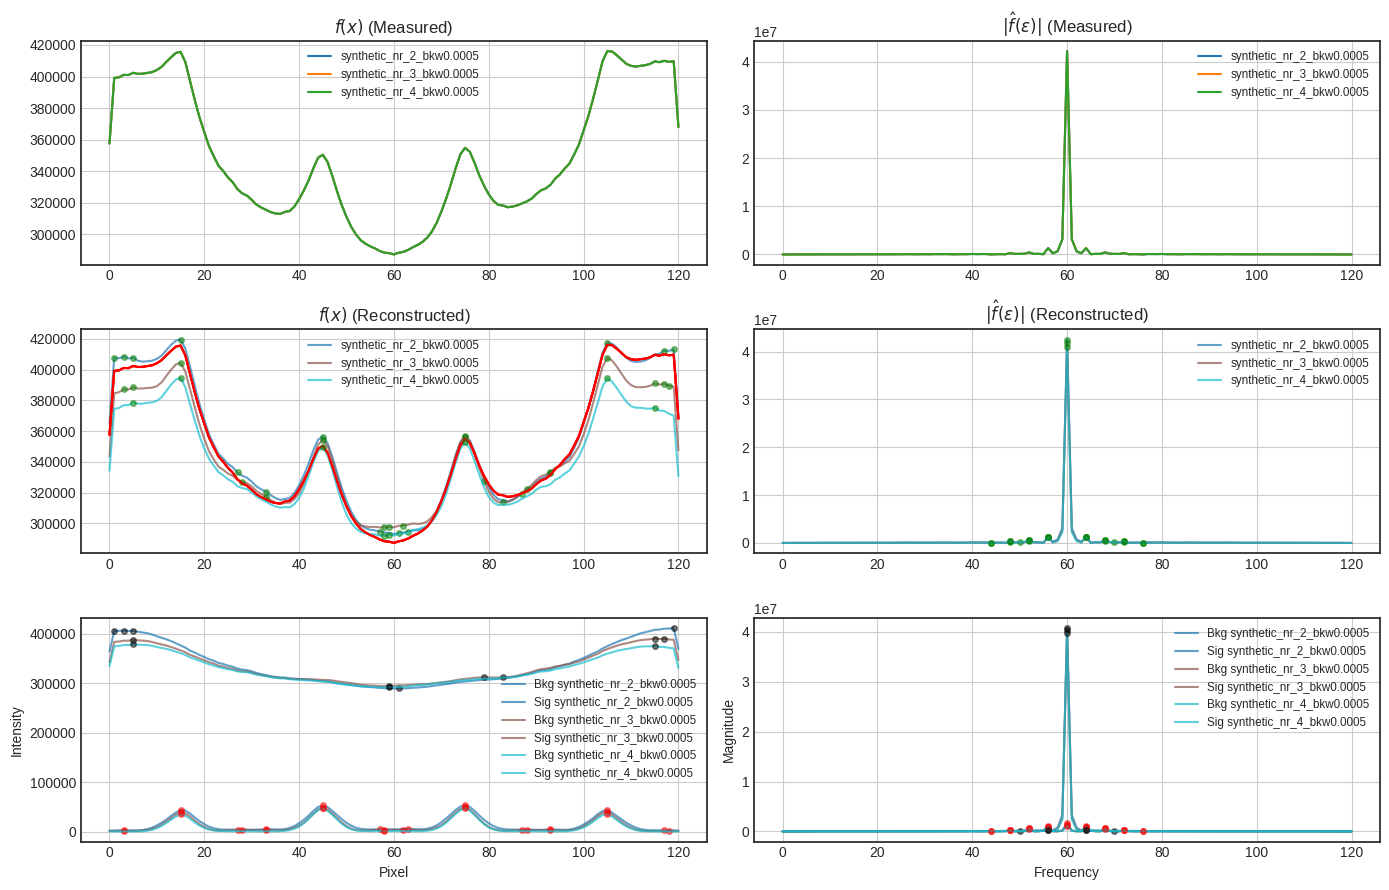

In [14]:
# Create a colormap with as many distinct colors as experiments
n_experiments = len(experiment_dirs)
cmap = cm.get_cmap('tab10', n_experiments)

# A helper function to create a unique legend (avoiding duplicate labels)
def unique_legend(ax):
    handles, labels = ax.get_legend_handles_labels()
    by_label = {}
    for handle, label in zip(handles, labels):
        if label not in by_label:
            by_label[label] = handle
    ax.legend(list(by_label.values()), list(by_label.keys()), fontsize='small', loc='best')

# Create overall figure with 3 rows x 2 columns of subplots.
fig, axes = plt.subplots(3, 2, figsize=(14, 9))

# Loop over experiments and add curves in each subplot.
for i,exp_dir in enumerate(experiment_dirs):

    color = cmap(i)

    npz_file = os.path.join(exp_dir, 'data_arrays.npz')
    data = np.load(npz_file)
    
    # Extract arrays
    S_expt_plot = data['s_exp_full_2d'].sum(-1).sum(-1)
    S_sig_plot  = data['s_sig_full_2d'].sum(-1).sum(-1)
    S_bkg_plot  = data['s_bkg_full_2d'].sum(-1).sum(-1)
 
    # Compute spatial projections (sum over rows)
    proj_exp = np.sum(S_expt_plot, axis=0)
    proj_sig = np.sum(S_sig_plot, axis=0)
    proj_bkg = np.sum(S_bkg_plot, axis=0)
    
    # Compute Fourier slices by taking the 2D FFT and selecting the middle row:
    slice_exp2 = np.fft.fftshift(np.fft.fft2(S_expt_plot))[S_expt_plot.shape[0] // 2]
    slice_sig2 = np.fft.fftshift(np.fft.fft2(S_sig_plot))[S_sig_plot.shape[0] // 2]
    slice_bkg2 = np.fft.fftshift(np.fft.fft2(S_bkg_plot))[S_bkg_plot.shape[0] // 2]
    
    # Use the directory's base name as the label.
    label = os.path.basename(exp_dir)
    
    # --------------------------
    # Row 0: "Truth" (measured) curves
    # Left: Spatial domain curve of measured data
    axes[0, 0].plot(proj_exp, label=label)
    axes[0, 0].set_title(r'$f(x)$ (Measured)')
    # Right: Fourier domain (absolute value) of measured data
    axes[0, 1].plot(np.abs(slice_exp2), label=label)
    axes[0, 1].set_title(r'$|\hat f(\epsilon)|$ (Measured)')

    # --------------------------
    # Row 1: "Reconstructed" curves (background + signal)
    # Left: Spatial reconstruction
    recon_spatial = proj_bkg + proj_sig
    axes[1, 0].plot(recon_spatial, color = color, alpha=0.7, label=label)
    axes[1, 0].plot(proj_exp, color = 'red')
    axes[1, 0].set_title(r'$f(x)$ (Reconstructed)')
    
    # Right: Fourier reconstruction from signal and background
    recon_freq = np.abs(slice_bkg2 + slice_sig2)
    axes[1, 1].plot(recon_freq, color=color, alpha=0.7, label=label)
    axes[1, 1].set_title(r'$|\hat f(\epsilon)|$ (Reconstructed)')
    
    # --------------------------
    # Row 2: Plots of signal and background separately
    # Left: Spatial domain: Plot background (black) and signal (red)
    axes[2, 0].plot(proj_bkg, color=color, alpha=0.7, label=f'Bkg {label}')
    axes[2, 0].plot(proj_sig, color=color, alpha=0.7, label=f'Sig {label}')
    
    if synthetic_data:
        proj_sig_truth = np.sum(s_sig_truth_2d.numpy() + 0, axis=0)
        proj_bkg_truth = np.sum(s_bkg_truth_2d.numpy() + 0 , axis=0)
        axes[2, 0].plot(proj_sig_truth, color='black', linestyle='--', label='True sig')
        axes[2, 0].plot(proj_bkg_truth, color='black', linestyle=':',  label='True bkg')

    axes[2, 0].set_xlabel('Pixel')
    axes[2, 0].set_ylabel('Intensity')
    
    # Right: Fourier domain: Plot background (black) and signal (red)
    axes[2, 1].plot(np.abs(slice_bkg2), color=color, alpha=0.7, label=f'Bkg {label}')
    axes[2, 1].plot(np.abs(slice_sig2), color=color, alpha=0.7, label=f'Sig {label}')
    axes[2, 1].set_xlabel('Frequency')
    axes[2, 1].set_ylabel('Magnitude')
    
    # --------------------------
    # Add local maxima to aid the comparison:
    
    # Frequency domain (row 2, col 2):
    mag_sig = np.abs(slice_sig2)
    mag_bkg = np.abs(slice_bkg2)
    idx1 = find_peaks(mag_sig, prominence=5e4)[0]
    idx2 = find_peaks(mag_bkg, prominence=5e4)[0]
    idx_union = np.union1d(idx1, idx2)
    
    # Mark the peaks on the Fourier domain individual plot (row 2, col 2)
    axes[2, 1].plot(idx1, mag_sig[idx1], 'ro', alpha=0.5, markersize=4)
    axes[2, 1].plot(idx2, mag_bkg[idx2], 'ko', alpha=0.5, markersize=4)
    
    # Mark the combined peaks on the reconstructed FFT curve (row 1, col 2)
    axes[1, 1].plot(idx_union, recon_freq[idx_union], 'go', alpha=0.5, markersize=4)
    
    # Spatial domain (row 2, col 1):
    idx1_spatial = find_peaks(proj_sig, prominence=5)[0]
    idx2_spatial = find_peaks(proj_bkg, prominence=5)[0]
    idx_union_spatial = np.union1d(idx1_spatial, idx2_spatial)
    
    # Mark the peaks on the individual curves of the spatial domain plot (row 2, col 1)
    axes[2, 0].plot(idx1_spatial, proj_sig[idx1_spatial], 'ro', alpha=0.5, markersize=4)
    axes[2, 0].plot(idx2_spatial, proj_bkg[idx2_spatial], 'ko', alpha=0.5, markersize=4)
    
    # Mark combined peaks on the reconstructed spatial signal (row 1, col 1)
    axes[1, 0].plot(idx_union_spatial, recon_spatial[idx_union_spatial], 'go', alpha=0.5, markersize=4)

# --------------------------
# Final formatting adjustments
for ax in axes.flat:
    ax.grid(True)
    # Use a smaller font-size for the legends if needed.
    ax.legend(fontsize='small', loc='best')

plt.style.use('seaborn-v0_8-white')
plt.tight_layout()

# Save the overall figure to a file
filename = os.path.join('../figures/', 'fourier_projection_slice_overall.png')
#plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

best plot
- nr_2_bkw0.0005 for experimental data
- nr_3_bkw0.005 for synthetic data

In [15]:
best_exp_dir = '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.0005'
data = np.load(os.path.join(best_exp_dir,'data_arrays.npz'))

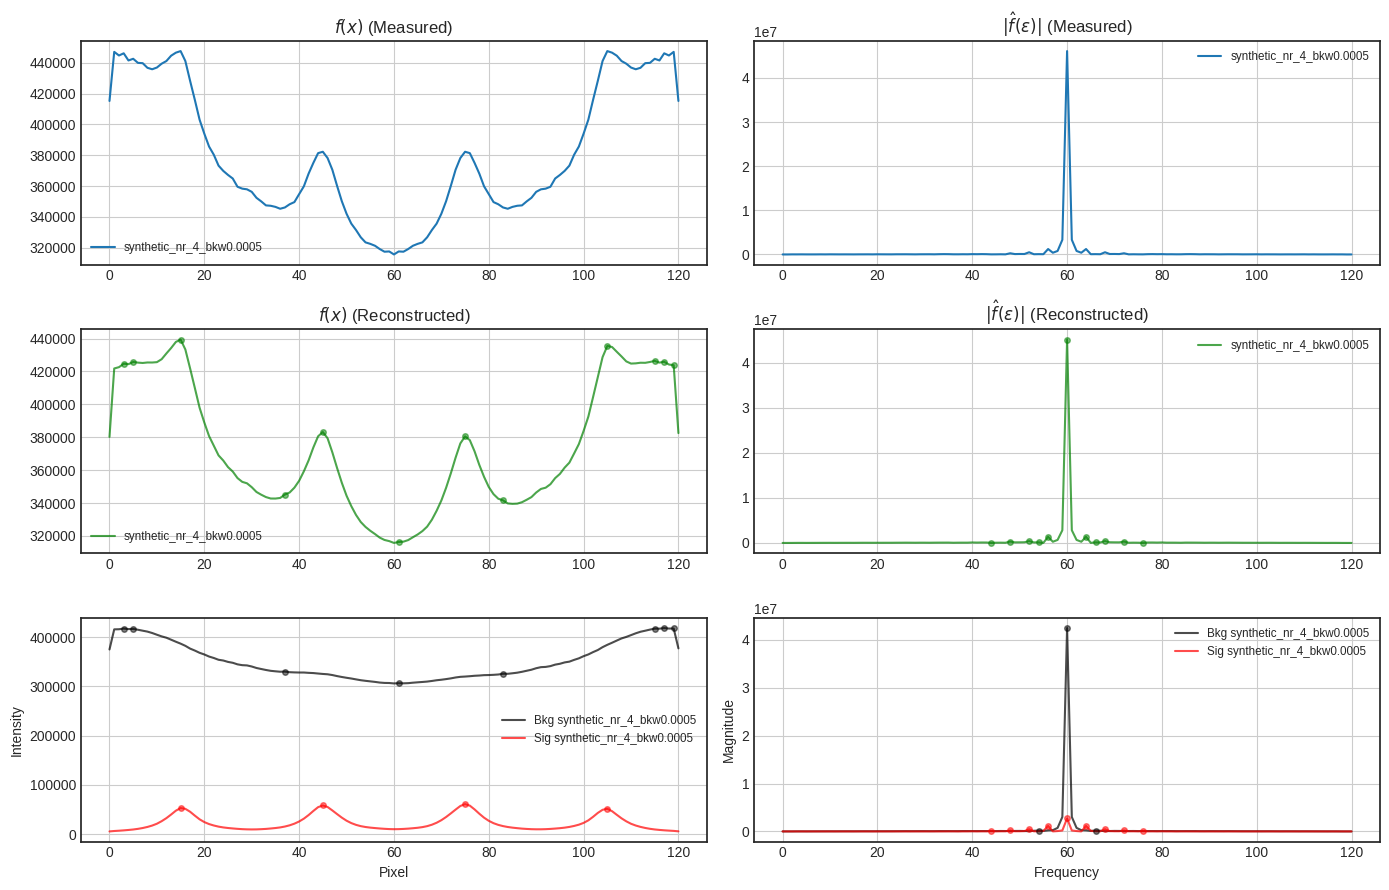

In [16]:

# Create overall figure with 3 rows x 2 columns of subplots.
fig, axes = plt.subplots(3, 2, figsize=(14, 9))

# Extract arrays
S_expt_plot = data['s_exp_full_2d'].sum(-1).sum(-1)
S_sig_plot  = data['s_sig_full_2d'].sum(-1).sum(-1)
S_bkg_plot  = data['s_bkg_full_2d'].sum(-1).sum(-1)
 
# Compute spatial projections (sum over rows)
proj_exp = np.sum(S_expt_plot, axis=0)
proj_sig = np.sum(S_sig_plot, axis=0)
proj_bkg = np.sum(S_bkg_plot, axis=0)
    
# Compute Fourier slices by taking the 2D FFT and selecting the middle row:
slice_exp2 = np.fft.fftshift(np.fft.fft2(S_expt_plot))[S_expt_plot.shape[0] // 2]
slice_sig2 = np.fft.fftshift(np.fft.fft2(S_sig_plot))[S_sig_plot.shape[0] // 2]
slice_bkg2 = np.fft.fftshift(np.fft.fft2(S_bkg_plot))[S_bkg_plot.shape[0] // 2]
    
# Use the directory's base name as the label.
label = os.path.basename(exp_dir)
    
# --------------------------
# Row 0: "Truth" (measured) curves
# Left: Spatial domain curve of measured data
axes[0, 0].plot(proj_exp, label=label)
axes[0, 0].set_title(r'$f(x)$ (Measured)')
# Right: Fourier domain (absolute value) of measured data
axes[0, 1].plot(np.abs(slice_exp2), label=label)
axes[0, 1].set_title(r'$|\hat f(\epsilon)|$ (Measured)')

# --------------------------
# Row 1: "Reconstructed" curves (background + signal)
# Left: Spatial reconstruction
recon_spatial = proj_bkg + proj_sig
axes[1, 0].plot(recon_spatial, color='green', alpha=0.7, label=label)
axes[1, 0].set_title(r'$f(x)$ (Reconstructed)')
    
# Right: Fourier reconstruction from signal and background
recon_freq = np.abs(slice_bkg2 + slice_sig2)
axes[1, 1].plot(recon_freq, color='green', alpha=0.7, label=label)
axes[1, 1].set_title(r'$|\hat f(\epsilon)|$ (Reconstructed)')
    
# --------------------------
# Row 2: Plots of signal and background separately
# Left: Spatial domain: Plot background (black) and signal (red)
axes[2, 0].plot(proj_bkg, color='black', alpha=0.7, label=f'Bkg {label}')
axes[2, 0].plot(proj_sig, color='red', alpha=0.7, label=f'Sig {label}')
axes[2, 0].set_xlabel('Pixel')
axes[2, 0].set_ylabel('Intensity')
    
# Right: Fourier domain: Plot background (black) and signal (red)
axes[2, 1].plot(np.abs(slice_bkg2), color='black', alpha=0.7, label=f'Bkg {label}')
axes[2, 1].plot(np.abs(slice_sig2), color='red', alpha=0.7, label=f'Sig {label}')
axes[2, 1].set_xlabel('Frequency')
axes[2, 1].set_ylabel('Magnitude')
    
# --------------------------
# Add local maxima to aid the comparison:
    
# Frequency domain (row 2, col 2):
mag_sig = np.abs(slice_sig2)
mag_bkg = np.abs(slice_bkg2)
idx1 = find_peaks(mag_sig, prominence=5e4)[0]
idx2 = find_peaks(mag_bkg, prominence=5e4)[0]
idx_union = np.union1d(idx1, idx2)
    
# Mark the peaks on the Fourier domain individual plot (row 2, col 2)
axes[2, 1].plot(idx1, mag_sig[idx1], 'ro', alpha=0.5, markersize=4)
axes[2, 1].plot(idx2, mag_bkg[idx2], 'ko', alpha=0.5, markersize=4)
    
# Mark the combined peaks on the reconstructed FFT curve (row 1, col 2)
axes[1, 1].plot(idx_union, recon_freq[idx_union], 'go', alpha=0.5, markersize=4)
    
# Spatial domain (row 2, col 1):
idx1_spatial = find_peaks(proj_sig, prominence=5)[0]
idx2_spatial = find_peaks(proj_bkg, prominence=5)[0]
idx_union_spatial = np.union1d(idx1_spatial, idx2_spatial)
    
# Mark the peaks on the individual curves of the spatial domain plot (row 2, col 1)
axes[2, 0].plot(idx1_spatial, proj_sig[idx1_spatial], 'ro', alpha=0.5, markersize=4)
axes[2, 0].plot(idx2_spatial, proj_bkg[idx2_spatial], 'ko', alpha=0.5, markersize=4)
    
# Mark combined peaks on the reconstructed spatial signal (row 1, col 1)
axes[1, 0].plot(idx_union_spatial, recon_spatial[idx_union_spatial], 'go', alpha=0.5, markersize=4)

# --------------------------
# Final formatting adjustments
for ax in axes.flat:
    ax.grid(True)
    # Use a smaller font-size for the legends if needed.
    ax.legend(fontsize='small', loc='best')

plt.style.use('seaborn-v0_8-white')
plt.tight_layout()

# Save the overall figure to a file
# filename = os.path.join('../figures/', 'fourier_projection_slice_overall.png')
# plt.savefig(filename, dpi=300, bbox_inches='tight')
plt.show()

Compare Pixel values
- best lambda is 5e-4
- to choose the neighbor range, we can look at the pixel difference

In [32]:
# List of experiment directories
experiment_dirs = [
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_2_bkw0.0005',
    '/pscratch/sd/z/zhantao/source_separation_plots/plots/synthetic_v1_nr_3_bkw0.005'
    # '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_3_bkw0.005',
    # '/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.0005',
]



2d works better than 4d

In [33]:
data['s_sig_full_2d'].shape, data['s_sig_2d'].shape

((121, 121, 30, 91), (30, 91, 100))

/tmp/ipykernel_2197989/784989648.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(experiment_dirs))


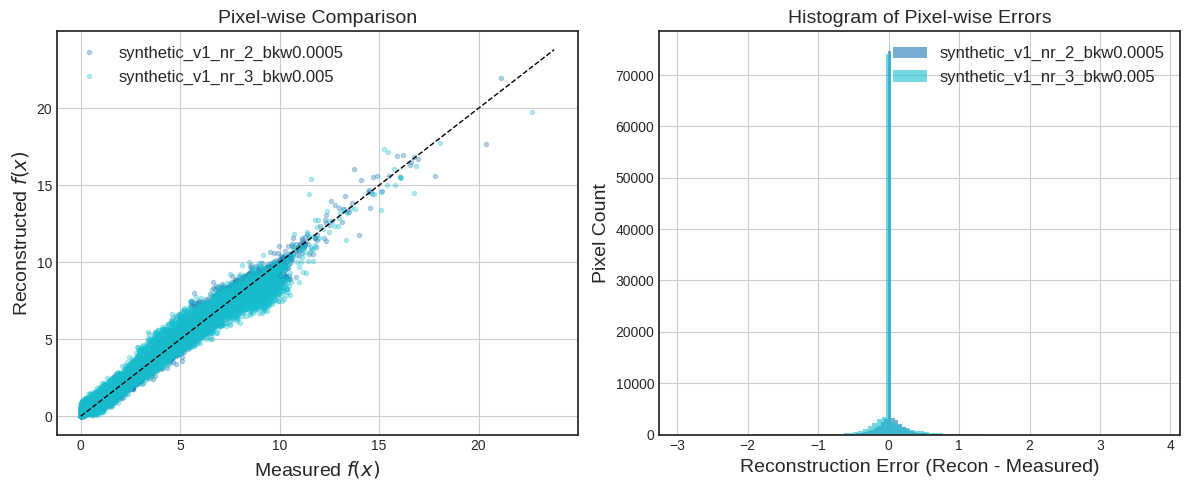

In [34]:
N_max = 100000  # max number of points to plot

# Setup colormap
cmap = cm.get_cmap('tab10', len(experiment_dirs))

# Create a figure with two subplots: (1) scatter, (2) histogram
fig, (ax_scatter, ax_hist) = plt.subplots(1, 2, figsize=(12, 5))

for i, exp_dir in enumerate(experiment_dirs):
    color = cmap(i)
    label = os.path.basename(exp_dir)
    
    # Load data
    npz_file = os.path.join(exp_dir, 'data_arrays.npz')
    data = np.load(npz_file)
    
    # Extract and flatten; 
    # #
    # 4d recon for experimantal data does not look good used 2d for experimental data
    # 4d recon for synthetic data looks good
    ##
    S_expt_plot = data['s_exp_full_2d'].flatten() #4d recon
    # S_expt_plot = data['s_exp_2d'].flatten() #2d

    S_sig_plot  = data['s_sig_full_2d'].flatten() #4d
    # S_sig_plot = data['s_sig_2d'].sum(0).flatten() #2d

    S_bkg_plot  = data['s_bkg_full_2d'].flatten() #4d
    # S_bkg_plot = data['s_bkg_2d'].sum(0).flatten() #2d

    S_sim_plot  = S_sig_plot + S_bkg_plot

    # Subsample
    N = len(S_expt_plot)
    if N > N_max:
        idx = np.random.choice(N, N_max, replace=False)
        S_expt_plot = S_expt_plot[idx]
        S_sim_plot  = S_sim_plot[idx]
        
    # Scatter plot of pixel-wise correspondence
    ax_scatter.plot(S_expt_plot, S_sim_plot, '.', alpha=0.3, color=color, label=label)
    
    # Histogram of pixel-wise error
    pixel_diff = S_sim_plot - S_expt_plot
    ax_hist.hist(pixel_diff, bins=100, alpha=0.6, color=color, label=label)

# Formatting the scatter plot
max_val = max(ax_scatter.get_xlim()[1], ax_scatter.get_ylim()[1])
ax_scatter.plot([0, max_val], [0, max_val], 'k--', lw=1)  # y = x line
ax_scatter.set_xlabel(r'Measured $f(x)$',fontsize = 14)
ax_scatter.set_ylabel(r'Reconstructed $f(x)$',fontsize = 14)
ax_scatter.set_title(r'Pixel-wise Comparison',fontsize = 14)
ax_scatter.grid(True)
ax_scatter.legend(fontsize='large', loc='upper left')

# Formatting the histogram
ax_hist.set_xlabel('Reconstruction Error (Recon - Measured)',fontsize = 14)
ax_hist.set_ylabel('Pixel Count',fontsize = 14)
ax_hist.set_title('Histogram of Pixel-wise Errors',fontsize = 14)
ax_hist.grid(True)
ax_hist.legend(fontsize='large', loc='upper right')
#ax_hist.set_xlim(-1,1)

plt.tight_layout()
plt.show()

In [35]:
import seaborn as sns
# Set a dark theme/style for Seaborn plots
plt.style.use('seaborn-v0_8-deep')

In [36]:
os.path.basename(experiment_dirs[1])

'synthetic_v1_nr_3_bkw0.005'

/tmp/ipykernel_2197989/3107403081.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(experiment_dirs))


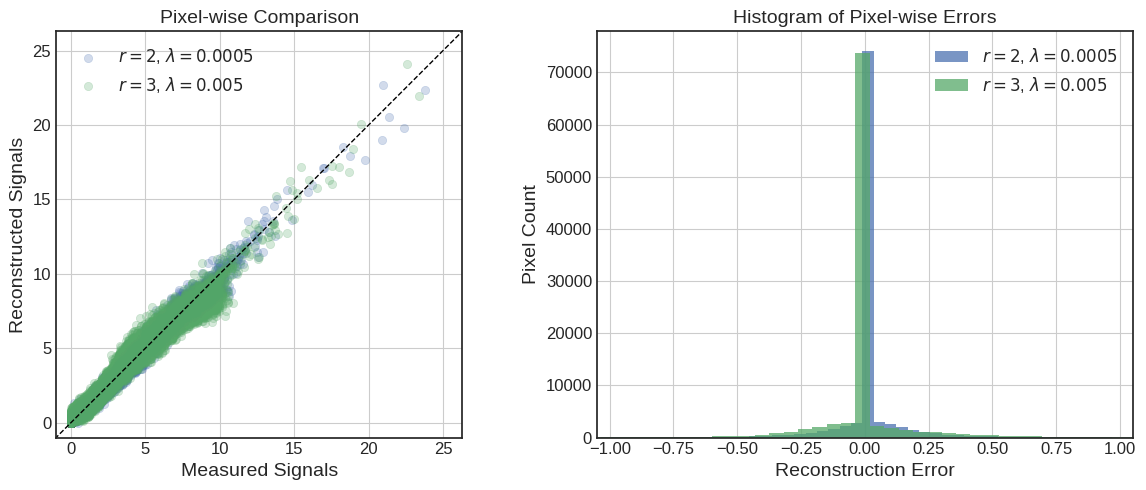

In [39]:
N_max = 100000  # max number of points to plot

# Setup colormap
cmap = cm.get_cmap('tab10', len(experiment_dirs))

# Create a figure with two subplots: (1) scatter, (2) histogram
fig, (ax_scatter, ax_hist) = plt.subplots(1, 2, figsize=(12, 5))

for i, exp_dir in enumerate(experiment_dirs):
    color = cmap(i)
    label = os.path.basename(exp_dir)
    if label == 'synthetic_v1_nr_3_bkw0.005':
        label = '$r = 3$, $\lambda = 0.005$'
    elif label == 'synthetic_v1_nr_2_bkw0.0005':
        label = '$r = 2$, $\lambda = 0.0005$'
    
    # Load data
    npz_file = os.path.join(exp_dir, 'data_arrays.npz')
    data = np.load(npz_file)
    
    # Extract and flatten; 
    # #
    # 4d recon for experimantal data does not look good used 2d for experimental data
    # 4d recon for synthetic data looks good
    ##
    S_expt_plot = data['s_exp_full_2d'].flatten() #4d recon
    # S_expt_plot = data['s_exp_2d'].flatten() #2d

    S_sig_plot  = data['s_sig_full_2d'].flatten() #4d
    # S_sig_plot = data['s_sig_2d'].sum(0).flatten() #2d

    S_bkg_plot  = data['s_bkg_full_2d'].flatten() #4d
    # S_bkg_plot = data['s_bkg_2d'].sum(0).flatten() #2d

    S_sim_plot  = S_sig_plot + S_bkg_plot

    # Subsample
    N = len(S_expt_plot)
    if N > N_max:
        idx = np.random.choice(N, N_max, replace=False)
        S_expt_plot = S_expt_plot[idx]
        S_sim_plot  = S_sim_plot[idx]
        
    # Scatter plot of pixel-wise correspondence
    # ax_scatter.plot(S_expt_plot, S_sim_plot, '.', alpha=0.3, color=color, label=label)
    sns.scatterplot(x=S_expt_plot, y=S_sim_plot, 
                 ax=ax_scatter, alpha=0.25, edgecolor=None, sizes=0.5,
                 label=label)

    # Histogram of pixel-wise error
    pixel_diff = S_sim_plot - S_expt_plot
    ax_hist.hist(pixel_diff, bins=100, alpha=0.75, label=label)

# Formatting the scatter plot
max_val = max(ax_scatter.get_xlim()[1], ax_scatter.get_ylim()[1])
ax_scatter.plot([-10, max_val+10], [-10, max_val+10], 'k--', lw=1)  # y = x line
ax_scatter.set_xlabel(r'Measured Signals',fontsize = 14)
ax_scatter.set_ylabel(r'Reconstructed Signals',fontsize = 14)
ax_scatter.set_title(r'Pixel-wise Comparison',fontsize = 14)
ax_scatter.grid(True)
ax_scatter.legend(fontsize='large', loc='upper left')
ax_scatter.set_xlim(-1, max_val+1)
ax_scatter.set_ylim(-1, max_val+1)
ax_scatter.set_aspect('equal', adjustable='box')

ax_scatter.tick_params(axis='both', which='major', labelsize=12)

# Formatting the histogram
ax_hist.set_xlabel('Reconstruction Error',fontsize = 14)
ax_hist.set_ylabel('Pixel Count',fontsize = 14)
ax_hist.set_title('Histogram of Pixel-wise Errors',fontsize = 14)
ax_hist.grid(True)
ax_hist.legend(fontsize='large', loc='upper right')
ax_hist.set_xlim(-1.05,1.05)
ax_hist.tick_params(axis='both', which='major', labelsize=12)
# ax_hist.set_yscale('log')

plt.tight_layout()
plt.savefig(os.path.join('../figures', 'hist_synthetic.png'), dpi=300, bbox_inches='tight')

plt.show()



Appendix Plots

In [25]:
experiment_dirs = ['/pscratch/sd/z/zhantao/source_separation_plots/plots/nr_2_bkw0.0005']
# experiment_dirs = ['/pscratch/sd/y/yn754/data/kernel-s2e/plots/nr_2_bkw0.0005']

452581.44


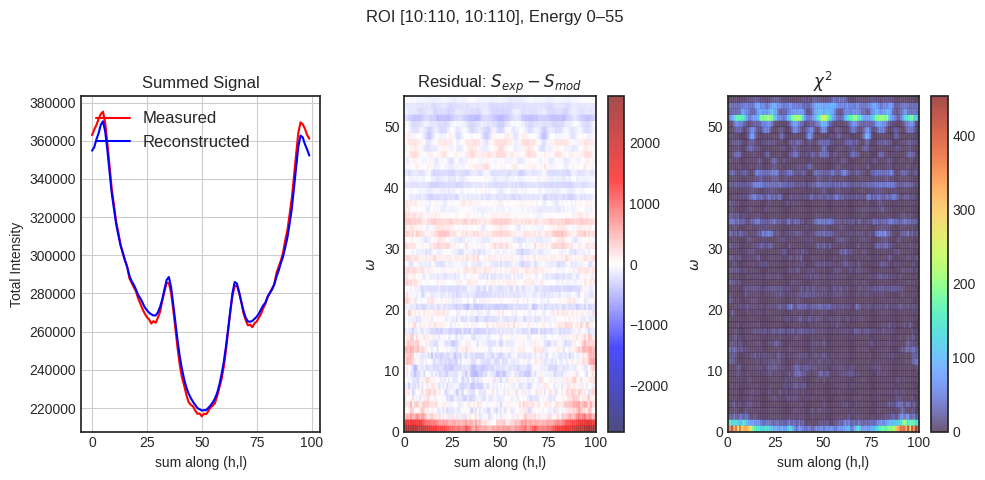

In [26]:
energy_bins = [0, 55]
x, y = 10, 110  # ROI

for b in range(len(energy_bins) - 1):
    en_range = range(energy_bins[b], energy_bins[b + 1])
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1, 3, 1)
    ax2 = fig.add_subplot(1, 3, 2)
    ax3 = fig.add_subplot(1, 3, 3)

    for i, exp_dir in enumerate(experiment_dirs):
        label = os.path.basename(exp_dir)
        npz_file = os.path.join(exp_dir, 'data_arrays.npz')
        data = np.load(npz_file)

        # Extract and compute
        S_expt_plot = data['s_exp_full_2d'][x:y, x:y, :, en_range].sum(-2).sum(axis=0)
        S_mod = data['s_sig_full_2d'][x:y, x:y, :, en_range].sum(-2).sum(axis=0) + \
                data['s_bkg_full_2d'][x:y, x:y, :, en_range].sum(-2).sum(axis=0)
        print(np.linalg.norm(S_mod))
        # Align by mean shift
        shift = (S_expt_plot - S_mod).mean()
        S_mod = S_mod + shift

        # Plot 1: Summed spectra
        ax1.plot(S_expt_plot.sum(-1), color='red', label='Measured')
        ax1.plot(S_mod.sum(-1), color='blue', label='Reconstructed')
        ax1.legend(fontsize='large', loc='upper left')
        ax1.set_title(f"Summed Signal")
        ax1.set_xlabel("sum along (h,l)")
        ax1.set_ylabel("Total Intensity")
        ax1.grid(True)

        # Plot 2: Residual map
        residual = (S_expt_plot - S_mod)
        vlim = np.max(np.abs(residual))
        c1 = ax2.pcolor(residual.T, cmap='seismic', alpha=0.7,edgecolor='face',vmin=-vlim, vmax=vlim, shading='auto')
        fig.colorbar(c1, ax=ax2)
        ax2.set_title("Residual: $S_{exp} - S_{mod}$")
        ax2.set_xlabel("sum along (h,l)")
        ax2.set_ylabel(r"$\omega$")

        # Plot 3: Normalized squared error
        err = np.where(S_expt_plot == 0, np.min(S_expt_plot[S_expt_plot > 0]), S_expt_plot)
        c2 = ax3.pcolor(((S_expt_plot - S_mod) ** 2 / err).T, alpha=0.7,cmap='turbo', vmin=0, shading='auto', edgecolor='face')
        fig.colorbar(c2, ax=ax3)
        ax3.set_title(r"$\chi^2$")
        ax3.set_xlabel("sum along (h,l)")
        ax3.set_ylabel(r"$\omega$")

    fig.suptitle(f"ROI [{x}:{y}, {x}:{y}], Energy {energy_bins[b]}–{energy_bins[b+1]}", fontsize=12)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.style.use('seaborn-v0_8-white')
    plt.savefig(f"../figures/projection_comparison_E{energy_bins[b]}_{energy_bins[b+1]}.pdf", dpi=300)
    plt.show()

In [ ]:
#load processed data
data_path = '/pscratch/sd/y/yn754/data/kernel-s2e/plots/nr_2_bkw0.0005'
data1 = np.load(os.path.join(data_path, 'data_arrays.npz'))
data_path = '/pscratch/sd/y/yn754/data/kernel-s2e/plots/nr_3_bkw0.0005'
data2 = np.load(os.path.join(data_path, 'data_arrays.npz'))

In [ ]:
data['s_exp_full_2d'].shape

(121, 121, 30, 91)

sum over various h and k for various l

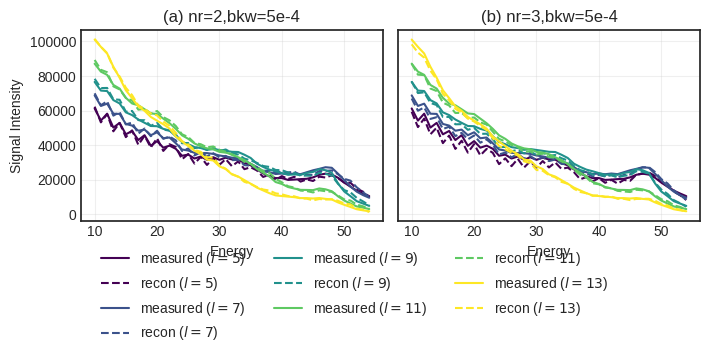

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# ROI and energy bins
x, y = 20, 100
en = range(10, 55)
energy_bins = np.array(en)

# Plot setup: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(7.2, 3), sharey=True)  # PRL two-column width
colors = plt.cm.viridis(np.linspace(0, 1, 5))

# Simulate two datasets: data1 and data2
datasets = [data1, data2]
titles = ["(a) nr=2,bkw=5e-4", "(b) nr=3,bkw=5e-4"]

for col, (data, title) in enumerate(zip(datasets, titles)):
    ax = axes[col]

    for idx, l in enumerate(range(5, 15, 2)):
        true = data['s_exp_full_2d'][:, :, l, en]
        ms   = data['s_bkg_full_2d'][:, :, l, en] + data['s_sig_full_2d'][:, :, l, en]

        truth_profile = np.abs(true.sum(0).sum(0))
        recon_profile = ms.sum(0).sum(0)

        ax.plot(energy_bins, truth_profile, color=colors[idx], linestyle='-',
                label=f"measured ($l={l}$)")
        ax.plot(energy_bins, recon_profile, color=colors[idx], linestyle='--',
                label=f"recon ($l={l}$)")

    ax.set_title(title)
    ax.set_xlabel(r"Energy")
    if col == 0:
        ax.set_ylabel("Signal Intensity")
    ax.grid(True, alpha=0.3)

# Create shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower center', bbox_to_anchor=(0.5, -0.2),
           frameon=False, ncol=3)

plt.tight_layout(rect=[0, 0.07, 1, 1])  # leave space at bottom for legend
#plt.savefig("../figures/recon_comparison_shared_legend.pdf", bbox_inches='tight', dpi=600)
plt.show()

sum over h and l for varying k

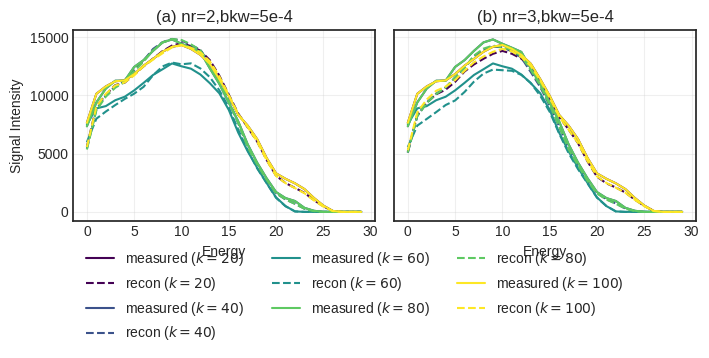

In [ ]:

# ROI and energy bins
x, y = 20, 100
en = range(10, 55)
#energy_bins = np.array(en)

# Plot setup: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(7.2, 3), sharey=True)  # PRL two-column width
colors = plt.cm.viridis(np.linspace(0, 1, 5))

# Simulate two datasets: data1 and data2
datasets = [data1, data2]
titles = ["(a) nr=2,bkw=5e-4", "(b) nr=3,bkw=5e-4"]

for col, (data, title) in enumerate(zip(datasets, titles)):
    ax = axes[col]

    for idx, k in enumerate(range(20, 120, 20)):
        true = data['s_exp_full_2d'][:, k, :, en]
        ms   = data['s_bkg_full_2d'][:, k, :, en] + data['s_sig_full_2d'][:, k, :, en]

        truth_profile = np.abs(true.sum(0).sum(0))
        recon_profile = ms.sum(0).sum(0)

        ax.plot(truth_profile, color=colors[idx], linestyle='-',
                label=f"measured ($k={k}$)")
        ax.plot(recon_profile, color=colors[idx], linestyle='--',
                label=f"recon ($k={k}$)")

    ax.set_title(title)
    ax.set_xlabel(r"Energy")
    if col == 0:
        ax.set_ylabel("Signal Intensity")
    ax.grid(True, alpha=0.3)

# Create shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower center', bbox_to_anchor=(0.5, -0.2),
           frameon=False, ncol=3)

plt.tight_layout(rect=[0, 0.07, 1, 1])  # leave space at bottom for legend
#plt.savefig("../figures/recon_comparison_shared_legend.pdf", bbox_inches='tight', dpi=600)
plt.show()